<a href="https://colab.research.google.com/github/Ajmyquira/Real-time-semantic-segmentation/blob/main/01_BiSeNet_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!wget --keep-session-cookies --save-cookies=cookies.txt --post-data "username=Ajmyquira&password=Gr34Aw.@f5o&submit=Login" https://www.cityscapes-dataset.com/login/

--2021-11-22 14:29:43--  https://www.cityscapes-dataset.com/login/
Resolving www.cityscapes-dataset.com (www.cityscapes-dataset.com)... 139.19.217.8
Connecting to www.cityscapes-dataset.com (www.cityscapes-dataset.com)|139.19.217.8|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.cityscapes-dataset.com/downloads/ [following]
--2021-11-22 14:29:43--  https://www.cityscapes-dataset.com/downloads/
Reusing existing connection to www.cityscapes-dataset.com:443.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘index.html’

index.html              [ <=>                ]  47.36K  --.-KB/s    in 0.03s   

2021-11-22 14:29:44 (1.44 MB/s) - ‘index.html’ saved [48495]



In [ ]:
!wget --load-cookies cookies.txt --content-disposition https://www.cityscapes-dataset.com/file-handling/?packageID=3

--2021-11-22 14:12:22--  https://www.cityscapes-dataset.com/file-handling/?packageID=3
Resolving www.cityscapes-dataset.com (www.cityscapes-dataset.com)... 139.19.217.8
Connecting to www.cityscapes-dataset.com (www.cityscapes-dataset.com)|139.19.217.8|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11592327197 (11G) [application/octet-stream]
Saving to: ‘leftImg8bit_trainvaltest.zip’

leftImg8bit_trainva 100%[===================>]  10.80G  24.3MB/s    in 7m 30s  

2021-11-22 14:19:54 (24.5 MB/s) - ‘leftImg8bit_trainvaltest.zip’ saved [11592327197/11592327197]



In [ ]:
!unzip leftImg8bit_trainvaltest.zip -d /content/drive/MyDrive/Colab_Notebooks/data

In [ ]:
!wget --load-cookies cookies.txt --content-disposition https://www.cityscapes-dataset.com/file-handling/?packageID=1

--2021-11-22 14:29:55--  https://www.cityscapes-dataset.com/file-handling/?packageID=1
Resolving www.cityscapes-dataset.com (www.cityscapes-dataset.com)... 139.19.217.8
Connecting to www.cityscapes-dataset.com (www.cityscapes-dataset.com)|139.19.217.8|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252567705 (241M) [application/octet-stream]
Saving to: ‘gtFine_trainvaltest.zip’

gtFine_trainvaltest 100%[===================>] 240.87M   105MB/s    in 2.3s    

2021-11-22 14:29:57 (105 MB/s) - ‘gtFine_trainvaltest.zip’ saved [252567705/252567705]



In [ ]:
!unzip gtFine_trainvaltest.zip -d /content/drive/MyDrive/Colab_Notebooks/data

# Testing the data

In [ ]:
from torchvision import transforms

input_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([.485, .456, .406], [.229, .224, .225]),
        ])

data_kwargs = {'transform': input_transform, 'base_size': 1024, 'crop_size': 768}

train_dataset = get_segmentation_dataset('citys', split='train', mode='train', **data_kwargs)
val_dataset = get_segmentation_dataset('citys', split='val', mode='val', **data_kwargs)
train_loader = data.DataLoader(dataset=train_dataset, batch_size=10, shuffle=True, drop_last=True)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=10, shuffle=False)

Found 2975 images in the folder /content/drive/MyDrive/Colab_Notebooks/data/leftImg8bit/train
Found 500 images in the folder /content/drive/MyDrive/Colab_Notebooks/data/leftImg8bit/val


In [ ]:
for data in train_loader:
  print(data)
  break

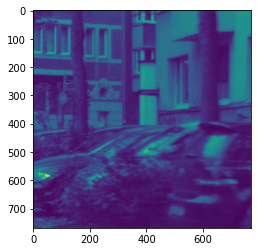

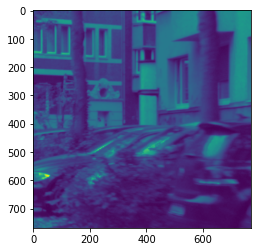

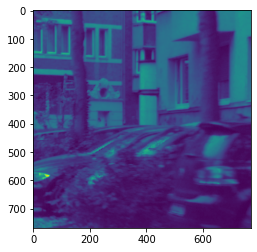

tensor([[ 8,  8,  8,  ...,  2,  2,  2],
        [ 8,  8,  8,  ...,  2,  2,  2],
        [ 8,  8,  8,  ...,  2,  2,  2],
        ...,
        [-1, -1, -1,  ..., 13, 13, 13],
        [-1, -1, -1,  ..., 13, 13, 13],
        [-1, -1, -1,  ..., 13, 13, 13]])


In [ ]:
import matplotlib.pyplot as plt

# imagen
plt.imshow(data[0][0][2].view(768, 768))
plt.show()
plt.imshow(data[0][0][1].view(768, 768))
plt.show()
plt.imshow(data[0][0][0].view(768, 768))
plt.show()

# label
y = data[1][0]
print(y)

# Implemantation

## Cargar el drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Imports

In [ ]:
import os
import math
import random
import time
import numpy as np
import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import threading

from PIL import Image, ImageOps, ImageFilter
from __future__ import division
from torchvision import transforms
from bisect import bisect_right

## Clase para la carga de datos

In [ ]:
__all__ = ['CitySegmentation']

class CitySegmentation(data.Dataset):
    BASE_DIR = 'cityscapes'
    NUM_CLASS = 19
    
    def __init__(self, root='/content/drive/MyDrive/Colab_Notebooks/data', split='train', mode=None, transform=None,
                 base_size=520, crop_size=480, **kwargs):
        super(CitySegmentation, self).__init__()
        self.root = root
        self.split = split
        self.mode = mode if mode is not None else split
        self.transform = transform
        self.base_size = base_size
        self.crop_size = crop_size
        self.images, self.mask_paths = _get_city_pairs(self.root, self.split)
        assert (len(self.images) == len(self.mask_paths))
        if len(self.images) == 0:
            raise RuntimeError("Found 0 images in subfolders of: " + self.root + "\n")
        self.valid_classes = [7, 8, 11, 12, 13, 17, 19, 20, 21, 22,
                              23, 24, 25, 26, 27, 28, 31, 32, 33]
        self._key = np.array([-1, -1, -1, -1, -1, -1,
                              -1, -1, 0, 1, -1, -1,
                              2, 3, 4, -1, -1, -1,
                              5, -1, 6, 7, 8, 9,
                              10, 11, 12, 13, 14, 15,
                              -1, -1, 16, 17, 18])
        self._mapping = np.array(range(-1, len(self._key) - 1)).astype('int32')

    def _class_to_index(self, mask):
        values = np.unique(mask)
        for value in values:
            assert (value in self._mapping)
        index = np.digitize(mask.ravel(), self._mapping, right=True)
        return self._key[index].reshape(mask.shape)

    def __getitem__(self, index):
        img = Image.open(self.images[index]).convert('RGB')
        if self.mode == 'test':
            if self.transform is not None:
                img = self.transform(img)
            return img, os.path.basename(self.images[index])
        mask = Image.open(self.mask_paths[index])
        # synchrosized transform
        if self.mode == 'train':
            img, mask = self._sync_transform(img, mask)
        elif self.mode == 'val':
            img, mask = self._val_sync_transform(img, mask)
        else:
            assert self.mode == 'testval'
            img, mask = self._img_transform(img), self._mask_transform(mask)
        # general resize, normalize and toTensor
        if self.transform is not None:
            img = self.transform(img)
        return img, mask

    def _val_sync_transform(self, img, mask):
        outsize = self.crop_size
        short_size = outsize
        w, h = img.size
        if w > h:
            oh = short_size
            ow = int(1.0 * w * oh / h)
        else:
            ow = short_size
            oh = int(1.0 * h * ow / w)
        img = img.resize((ow, oh), Image.BILINEAR)
        mask = mask.resize((ow, oh), Image.NEAREST)
        # center crop
        w, h = img.size
        x1 = int(round((w - outsize) / 2.))
        y1 = int(round((h - outsize) / 2.))
        img = img.crop((x1, y1, x1 + outsize, y1 + outsize))
        mask = mask.crop((x1, y1, x1 + outsize, y1 + outsize))
        # final transform
        img, mask = self._img_transform(img), self._mask_transform(mask)
        return img, mask

    def _sync_transform(self, img, mask):
        # random mirror
        if random.random() < 0.5:
            img = img.transpose(Image.FLIP_LEFT_RIGHT)
            mask = mask.transpose(Image.FLIP_LEFT_RIGHT)
        crop_size = self.crop_size
        # random scale (short edge)
        short_size = random.randint(int(self.base_size * 0.5), int(self.base_size * 2.0))
        w, h = img.size
        if h > w:
            ow = short_size
            oh = int(1.0 * h * ow / w)
        else:
            oh = short_size
            ow = int(1.0 * w * oh / h)
        img = img.resize((ow, oh), Image.BILINEAR)
        mask = mask.resize((ow, oh), Image.NEAREST)
        # pad crop
        if short_size < crop_size:
            padh = crop_size - oh if oh < crop_size else 0
            padw = crop_size - ow if ow < crop_size else 0
            img = ImageOps.expand(img, border=(0, 0, padw, padh), fill=0)
            mask = ImageOps.expand(mask, border=(0, 0, padw, padh), fill=0)
        # random crop crop_size
        w, h = img.size
        x1 = random.randint(0, w - crop_size)
        y1 = random.randint(0, h - crop_size)
        img = img.crop((x1, y1, x1 + crop_size, y1 + crop_size))
        mask = mask.crop((x1, y1, x1 + crop_size, y1 + crop_size))
        # gaussian blur as in PSP
        if random.random() < 0.5:
            img = img.filter(ImageFilter.GaussianBlur(
                radius=random.random()))
        # final transform
        img, mask = self._img_transform(img), self._mask_transform(mask)
        return img, mask

    def _img_transform(self, img):
        return np.array(img)

    def _mask_transform(self, mask):
        target = self._class_to_index(np.array(mask).astype('int32'))
        return torch.LongTensor(np.array(target).astype('int32'))

    def __len__(self):
        return len(self.images)

    @property
    def num_class(self):
        """Number of categories."""
        return self.NUM_CLASS

    @property
    def pred_offset(self):
        return 0


def _get_city_pairs(folder, split='train'):
    def get_path_pairs(img_folder, mask_folder):
        img_paths = []
        mask_paths = []
        for root, _, files in os.walk(img_folder):
            for filename in files:
                if filename.endswith(".png"):
                    imgpath = os.path.join(root, filename)
                    foldername = os.path.basename(os.path.dirname(imgpath))
                    maskname = filename.replace('leftImg8bit', 'gtFine_labelIds')
                    maskpath = os.path.join(mask_folder, foldername, maskname)
                    if os.path.isfile(imgpath) and os.path.isfile(maskpath):
                        img_paths.append(imgpath)
                        mask_paths.append(maskpath)
                    else:
                        print('cannot find the mask or image:', imgpath, maskpath)
        print('Found {} images in the folder {}'.format(len(img_paths), img_folder))
        return img_paths, mask_paths

    if split in ('train', 'val'):
        img_folder = os.path.join(folder, 'leftImg8bit/' + split)
        mask_folder = os.path.join(folder, 'gtFine/' + split)
        img_paths, mask_paths = get_path_pairs(img_folder, mask_folder)
        return img_paths, mask_paths
    else:
        assert split == 'trainval'
        print('trainval set')
        train_img_folder = os.path.join(folder, 'leftImg8bit/train')
        train_mask_folder = os.path.join(folder, 'gtFine/train')
        val_img_folder = os.path.join(folder, 'leftImg8bit/val')
        val_mask_folder = os.path.join(folder, 'gtFine/val')
        train_img_paths, train_mask_paths = get_path_pairs(train_img_folder, train_mask_folder)
        val_img_paths, val_mask_paths = get_path_pairs(val_img_folder, val_mask_folder)
        img_paths = train_img_paths + val_img_paths
        mask_paths = train_mask_paths + val_mask_paths
    return img_paths, mask_paths

datasets = {
    'citys': CitySegmentation,
}

def get_segmentation_dataset(name, **kwargs):
    """Segmentation Datasets"""
    return datasets[name.lower()](**kwargs)

## Clases del modelo

In [ ]:
class ConvBNReLU(nn.Module):

    def __init__(self, in_chan, out_chan, ks=3, stride=1, padding=1,
                 dilation=1, groups=1, bias=False):
        super(ConvBNReLU, self).__init__()
        self.conv = nn.Conv2d(
                in_chan, out_chan, kernel_size=ks, stride=stride,
                padding=padding, dilation=dilation,
                groups=groups, bias=bias)
        self.bn = nn.BatchNorm2d(out_chan)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        feat = self.conv(x)
        feat = self.bn(feat)
        feat = self.relu(feat)
        return feat

In [ ]:
class DetailBranch(nn.Module):

    def __init__(self):
        super(DetailBranch, self).__init__()
        self.S1 = nn.Sequential(
            ConvBNReLU(3, 64, 3, stride=2),
            ConvBNReLU(64, 64, 3, stride=1),
        )
        self.S2 = nn.Sequential(
            ConvBNReLU(64, 64, 3, stride=2),
            ConvBNReLU(64, 64, 3, stride=1),
            ConvBNReLU(64, 64, 3, stride=1),
        )
        self.S3 = nn.Sequential(
            ConvBNReLU(64, 128, 3, stride=2),
            ConvBNReLU(128, 128, 3, stride=1),
            ConvBNReLU(128, 128, 3, stride=1),
        )

    def forward(self, x):
        feat = self.S1(x)
        feat = self.S2(feat)
        feat = self.S3(feat)
        return feat

In [ ]:
class StemBlock(nn.Module):

    def __init__(self):
        super(StemBlock, self).__init__()
        self.conv = ConvBNReLU(3, 16, 3, stride=2)
        self.left = nn.Sequential(
            ConvBNReLU(16, 8, 1, stride=1, padding=0),
            ConvBNReLU(8, 16, 3, stride=2),
        )
        self.right = nn.MaxPool2d(
            kernel_size=3, stride=2, padding=1, ceil_mode=False)
        self.fuse = ConvBNReLU(32, 16, 3, stride=1)

    def forward(self, x):
        feat = self.conv(x)
        feat_left = self.left(feat)
        feat_right = self.right(feat)
        feat = torch.cat([feat_left, feat_right], dim=1)
        feat = self.fuse(feat)
        return feat

In [ ]:
class CEBlock(nn.Module):

    def __init__(self):
        super(CEBlock, self).__init__()
        self.bn = nn.BatchNorm2d(128)
        self.conv_gap = ConvBNReLU(128, 128, 1, stride=1, padding=0)
        #TODO: in paper here is naive conv2d, no bn-relu
        self.conv_last = ConvBNReLU(128, 128, 3, stride=1)

    def forward(self, x):
        feat = torch.mean(x, dim=(2, 3), keepdim=True)
        feat = self.bn(feat)
        feat = self.conv_gap(feat)
        feat = feat + x
        feat = self.conv_last(feat)
        return feat

In [ ]:
class GELayerS1(nn.Module):

    def __init__(self, in_chan, out_chan, exp_ratio=6):
        super(GELayerS1, self).__init__()
        mid_chan = in_chan * exp_ratio
        self.conv1 = ConvBNReLU(in_chan, in_chan, 3, stride=1)
        self.dwconv = nn.Sequential(
            nn.Conv2d(
                in_chan, mid_chan, kernel_size=3, stride=1,
                padding=1, groups=in_chan, bias=False),
            nn.BatchNorm2d(mid_chan),
            nn.ReLU(inplace=True), # not shown in paper
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                mid_chan, out_chan, kernel_size=1, stride=1,
                padding=0, bias=False),
            nn.BatchNorm2d(out_chan),
        )
        self.conv2[1].last_bn = True
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        feat = self.conv1(x)
        feat = self.dwconv(feat)
        feat = self.conv2(feat)
        feat = feat + x
        feat = self.relu(feat)
        return feat

In [ ]:
class GELayerS2(nn.Module):

    def __init__(self, in_chan, out_chan, exp_ratio=6):
        super(GELayerS2, self).__init__()
        mid_chan = in_chan * exp_ratio
        self.conv1 = ConvBNReLU(in_chan, in_chan, 3, stride=1)
        self.dwconv1 = nn.Sequential(
            nn.Conv2d(
                in_chan, mid_chan, kernel_size=3, stride=2,
                padding=1, groups=in_chan, bias=False),
            nn.BatchNorm2d(mid_chan),
        )
        self.dwconv2 = nn.Sequential(
            nn.Conv2d(
                mid_chan, mid_chan, kernel_size=3, stride=1,
                padding=1, groups=mid_chan, bias=False),
            nn.BatchNorm2d(mid_chan),
            nn.ReLU(inplace=True), # not shown in paper
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                mid_chan, out_chan, kernel_size=1, stride=1,
                padding=0, bias=False),
            nn.BatchNorm2d(out_chan),
        )
        self.conv2[1].last_bn = True
        self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_chan, in_chan, kernel_size=3, stride=2,
                    padding=1, groups=in_chan, bias=False),
                nn.BatchNorm2d(in_chan),
                nn.Conv2d(
                    in_chan, out_chan, kernel_size=1, stride=1,
                    padding=0, bias=False),
                nn.BatchNorm2d(out_chan),
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        feat = self.conv1(x)
        feat = self.dwconv1(feat)
        feat = self.dwconv2(feat)
        feat = self.conv2(feat)
        shortcut = self.shortcut(x)
        feat = feat + shortcut
        feat = self.relu(feat)
        return feat

In [ ]:
class SegmentBranch(nn.Module):

    def __init__(self):
        super(SegmentBranch, self).__init__()
        self.S1S2 = StemBlock()
        self.S3 = nn.Sequential(
            GELayerS2(16, 32),
            GELayerS1(32, 32),
        )
        self.S4 = nn.Sequential(
            GELayerS2(32, 64),
            GELayerS1(64, 64),
        )
        self.S5_4 = nn.Sequential(
            GELayerS2(64, 128),
            GELayerS1(128, 128),
            GELayerS1(128, 128),
            GELayerS1(128, 128),
        )
        self.S5_5 = CEBlock()

    def forward(self, x):
        feat2 = self.S1S2(x)
        feat3 = self.S3(feat2)
        feat4 = self.S4(feat3)
        feat5_4 = self.S5_4(feat4)
        feat5_5 = self.S5_5(feat5_4)
        return feat2, feat3, feat4, feat5_4, feat5_5

In [ ]:
class BGALayer(nn.Module):

    def __init__(self):
        super(BGALayer, self).__init__()
        self.left1 = nn.Sequential(
            nn.Conv2d(
                128, 128, kernel_size=3, stride=1,
                padding=1, groups=128, bias=False),
            nn.BatchNorm2d(128),
            nn.Conv2d(
                128, 128, kernel_size=1, stride=1,
                padding=0, bias=False),
        )
        self.left2 = nn.Sequential(
            nn.Conv2d(
                128, 128, kernel_size=3, stride=2,
                padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.AvgPool2d(kernel_size=3, stride=2, padding=1, ceil_mode=False)
        )
        self.right1 = nn.Sequential(
            nn.Conv2d(
                128, 128, kernel_size=3, stride=1,
                padding=1, bias=False),
            nn.BatchNorm2d(128),
        )
        self.right2 = nn.Sequential(
            nn.Conv2d(
                128, 128, kernel_size=3, stride=1,
                padding=1, groups=128, bias=False),
            nn.BatchNorm2d(128),
            nn.Conv2d(
                128, 128, kernel_size=1, stride=1,
                padding=0, bias=False),
        )
        ##TODO: does this really has no relu?
        self.conv = nn.Sequential(
            nn.Conv2d(
                128, 128, kernel_size=3, stride=1,
                padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True), # not shown in paper
        )

    def forward(self, x_d, x_s):
        dsize = x_d.size()[2:]
        left1 = self.left1(x_d)
        left2 = self.left2(x_d)
        right1 = self.right1(x_s)
        right2 = self.right2(x_s)
        right1 = F.interpolate(
            right1, size=dsize, mode='bilinear', align_corners=True)
        left = left1 * torch.sigmoid(right1)
        right = left2 * torch.sigmoid(right2)
        right = F.interpolate(
            right, size=dsize, mode='bilinear', align_corners=True)
        out = self.conv(left + right)
        return out

In [ ]:
class SegmentHead(nn.Module):

    def __init__(self, in_chan, mid_chan, n_classes):
        super(SegmentHead, self).__init__()
        self.conv = ConvBNReLU(in_chan, mid_chan, 3, stride=1)
        self.drop = nn.Dropout(0.1)
        self.conv_out = nn.Conv2d(
                mid_chan, n_classes, kernel_size=1, stride=1,
                padding=0, bias=True)

    def forward(self, x, size=None):
        feat = self.conv(x)
        feat = self.drop(feat)
        feat = self.conv_out(feat)
        if not size is None:
            feat = F.interpolate(feat, size=size,
                mode='bilinear', align_corners=True)
        return feat

In [ ]:
class BiSeNetV2(nn.Module):

    def __init__(self, n_classes):
        super(BiSeNetV2, self).__init__()
        self.detail = DetailBranch()
        self.segment = SegmentBranch()
        self.bga = BGALayer()

        ## TODO: what is the number of mid chan ?
        self.head = SegmentHead(128, 1024, n_classes)
        self.aux2 = SegmentHead(16, 128, n_classes)
        self.aux3 = SegmentHead(32, 128, n_classes)
        self.aux4 = SegmentHead(64, 128, n_classes)
        self.aux5_4 = SegmentHead(128, 128, n_classes)

        self.init_weights()

    def forward(self, x):
        size = x.size()[2:]
        feat_d = self.detail(x)
        feat2, feat3, feat4, feat5_4, feat_s = self.segment(x)
        feat_head = self.bga(feat_d, feat_s)

        logits = self.head(feat_head, size)
        logits_aux2 = self.aux2(feat2, size)
        logits_aux3 = self.aux3(feat3, size)
        logits_aux4 = self.aux4(feat4, size)
        logits_aux5_4 = self.aux5_4(feat5_4, size)
        return logits, logits_aux2, logits_aux3, logits_aux4, logits_aux5_4

    def init_weights(self):
        for name, module in self.named_modules():
            if isinstance(module, (nn.Conv2d, nn.Linear)):
                nn.init.kaiming_normal_(module.weight, mode='fan_out')
                if not module.bias is None: nn.init.constant_(module.bias, 0)
            elif isinstance(module, nn.modules.batchnorm._BatchNorm):
                if hasattr(module, 'last_bn') and module.last_bn:
                    nn.init.zeros_(module.weight)
                else:
                    nn.init.ones_(module.weight)
                nn.init.zeros_(module.bias)

### Funcion get()

In [ ]:
def get_bisenet_v2(dataset='citys', pretrained=False, root='./weights', map_cpu=False, **kwargs):
    model = BiSeNetV2(19)
    if pretrained:
        if(map_cpu):
            model.load_state_dict(torch.load(os.path.join(root, 'bisenetv2_citys.pth'), map_location='cpu'))
        else:
            model.load_state_dict(torch.load(os.path.join(root, 'bisenetv2_citys.pth')))
    return model

## Clase metricas

In [ ]:
class SegmentationMetric(object):
    """Computes pixAcc and mIoU metric scores
    """

    def __init__(self, nclass):
        super(SegmentationMetric, self).__init__()
        self.nclass = nclass
        self.lock = threading.Lock()
        self.reset()

    def update(self, preds, labels):
        """Updates the internal evaluation result.
        Parameters
        ----------
        labels : 'NumpyArray' or list of `NumpyArray`
            The labels of the data.
        preds : 'NumpyArray' or list of `NumpyArray`
            Predicted values.
        """
        if isinstance(preds, np.ndarray):
            self.evaluate_worker(preds, labels)
        elif isinstance(preds, (list, tuple)):
            threads = [threading.Thread(target=self.evaluate_worker, args=(pred, label), )
                       for (pred, label) in zip(preds, labels)]
            for thread in threads:
                thread.start()
            for thread in threads:
                thread.join()

    def get(self):
        """Gets the current evaluation result.
        Returns
        -------
        metrics : tuple of float
            pixAcc and mIoU
        """
        pixAcc = 1.0 * self.total_correct / (np.spacing(1) + self.total_label)
        IoU = 1.0 * self.total_inter / (np.spacing(1) + self.total_union)
        # It has same result with np.nanmean() when all class exist
        mIoU = IoU.mean()
        return pixAcc, mIoU

    def evaluate_worker(self, pred, label):
        correct, labeled = batch_pix_accuracy(pred, label)
        inter, union = batch_intersection_union(pred, label, self.nclass)
        with self.lock:
            self.total_correct += correct
            self.total_label += labeled
            self.total_inter += inter
            self.total_union += union

    def reset(self):
        """Resets the internal evaluation result to initial state."""
        self.total_inter = 0
        self.total_union = 0
        self.total_correct = 0
        self.total_label = 0


def batch_pix_accuracy(predict, target):
    """PixAcc"""
    # inputs are numpy array, output 4D, target 3D
    assert predict.shape == target.shape
    predict = predict.astype('int64') + 1
    target = target.astype('int64') + 1

    pixel_labeled = np.sum(target > 0)
    pixel_correct = np.sum((predict == target) * (target > 0))
    assert pixel_correct <= pixel_labeled, "Correct area should be smaller than Labeled"
    return pixel_correct, pixel_labeled


def batch_intersection_union(predict, target, nclass):
    """mIoU"""
    # inputs are numpy array, output 4D, target 3D
    assert predict.shape == target.shape
    mini = 1
    maxi = nclass
    nbins = nclass
    predict = predict.astype('int64') + 1
    target = target.astype('int64') + 1

    predict = predict * (target > 0).astype(predict.dtype)
    intersection = predict * (predict == target)
    # areas of intersection and union
    # element 0 in intersection occur the main difference from np.bincount. set boundary to -1 is necessary.
    area_inter, _ = np.histogram(intersection, bins=nbins, range=(mini, maxi))
    area_pred, _ = np.histogram(predict, bins=nbins, range=(mini, maxi))
    area_lab, _ = np.histogram(target, bins=nbins, range=(mini, maxi))
    area_union = area_pred + area_lab - area_inter
    assert (area_inter <= area_union).all(), "Intersection area should be smaller than Union area"
    return area_inter, area_union


def pixelAccuracy(imPred, imLab):
    """
    This function takes the prediction and label of a single image, returns pixel-wise accuracy
    To compute over many images do:
    for i = range(Nimages):
         (pixel_accuracy[i], pixel_correct[i], pixel_labeled[i]) = \
            pixelAccuracy(imPred[i], imLab[i])
    mean_pixel_accuracy = 1.0 * np.sum(pixel_correct) / (np.spacing(1) + np.sum(pixel_labeled))
    """
    # Remove classes from unlabeled pixels in gt image.
    # We should not penalize detections in unlabeled portions of the image.
    pixel_labeled = np.sum(imLab >= 0)
    pixel_correct = np.sum((imPred == imLab) * (imLab >= 0))
    pixel_accuracy = 1.0 * pixel_correct / pixel_labeled
    return (pixel_accuracy, pixel_correct, pixel_labeled)


def intersectionAndUnion(imPred, imLab, numClass):
    """
    This function takes the prediction and label of a single image,
    returns intersection and union areas for each class
    To compute over many images do:
    for i in range(Nimages):
        (area_intersection[:,i], area_union[:,i]) = intersectionAndUnion(imPred[i], imLab[i])
    IoU = 1.0 * np.sum(area_intersection, axis=1) / np.sum(np.spacing(1)+area_union, axis=1)
    """
    # Remove classes from unlabeled pixels in gt image.
    # We should not penalize detections in unlabeled portions of the image.
    imPred = imPred * (imLab >= 0)

    # Compute area intersection:
    intersection = imPred * (imPred == imLab)
    (area_intersection, _) = np.histogram(intersection, bins=numClass, range=(1, numClass))

    # Compute area union:
    (area_pred, _) = np.histogram(imPred, bins=numClass, range=(1, numClass))
    (area_lab, _) = np.histogram(imLab, bins=numClass, range=(1, numClass))
    area_union = area_pred + area_lab - area_intersection
    return (area_intersection, area_union)


def hist_info(pred, label, num_cls):
    assert pred.shape == label.shape
    k = (label >= 0) & (label < num_cls)
    labeled = np.sum(k)
    correct = np.sum((pred[k] == label[k]))

    return np.bincount(num_cls * label[k].astype(int) + pred[k], minlength=num_cls ** 2).reshape(num_cls,
                                                                                                 num_cls), labeled, correct


def compute_score(hist, correct, labeled):
    iu = np.diag(hist) / (hist.sum(1) + hist.sum(0) - np.diag(hist))
    # print('right')
    # print(iu)
    mean_IU = np.nanmean(iu)
    mean_IU_no_back = np.nanmean(iu[1:])
    freq = hist.sum(1) / hist.sum()
    freq_IU = (iu[freq > 0] * freq[freq > 0]).sum()
    mean_pixel_acc = correct / labeled

    return iu, mean_IU, mean_IU_no_back, mean_pixel_acc

## Training

### Lr_scheduler

In [ ]:
class WarmupLrScheduler(torch.optim.lr_scheduler._LRScheduler):

    def __init__(
            self,
            optimizer,
            warmup_iter=500,
            warmup_ratio=5e-4,
            warmup='exp',
            last_epoch=-1,
    ):
        self.warmup_iter = warmup_iter
        self.warmup_ratio = warmup_ratio
        self.warmup = warmup
        super(WarmupLrScheduler, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        ratio = self.get_lr_ratio()
        lrs = [ratio * lr for lr in self.base_lrs]
        return lrs

    def get_lr_ratio(self):
        if self.last_epoch < self.warmup_iter:
            ratio = self.get_warmup_ratio()
        else:
            ratio = self.get_main_ratio()
        return ratio

    def get_main_ratio(self):
        raise NotImplementedError

    def get_warmup_ratio(self):
        assert self.warmup in ('linear', 'exp')
        alpha = self.last_epoch / self.warmup_iter
        if self.warmup == 'linear':
            ratio = self.warmup_ratio + (1 - self.warmup_ratio) * alpha
        elif self.warmup == 'exp':
            ratio = self.warmup_ratio ** (1. - alpha)
        return ratio


class WarmupPolyLrScheduler(WarmupLrScheduler):

    def __init__(
            self,
            optimizer,
            power,
            max_iter,
            warmup_iter=500,
            warmup_ratio=5e-4,
            warmup='exp',
            last_epoch=-1,
    ):
        self.power = power
        self.max_iter = max_iter
        super(WarmupPolyLrScheduler, self).__init__(
            optimizer, warmup_iter, warmup_ratio, warmup, last_epoch)

    def get_main_ratio(self):
        real_iter = self.last_epoch - self.warmup_iter
        real_max_iter = self.max_iter - self.warmup_iter
        alpha = real_iter / real_max_iter
        ratio = (1 - alpha) ** self.power
        return ratio


class WarmupExpLrScheduler(WarmupLrScheduler):

    def __init__(
            self,
            optimizer,
            gamma,
            interval=1,
            warmup_iter=500,
            warmup_ratio=5e-4,
            warmup='exp',
            last_epoch=-1,
    ):
        self.gamma = gamma
        self.interval = interval
        super(WarmupExpLrScheduler, self).__init__(
            optimizer, warmup_iter, warmup_ratio, warmup, last_epoch)

    def get_main_ratio(self):
        real_iter = self.last_epoch - self.warmup_iter
        ratio = self.gamma ** (real_iter // self.interval)
        return ratio


class WarmupCosineLrScheduler(WarmupLrScheduler):

    def __init__(
            self,
            optimizer,
            max_iter,
            eta_ratio=0,
            warmup_iter=500,
            warmup_ratio=5e-4,
            warmup='exp',
            last_epoch=-1,
    ):
        self.eta_ratio = eta_ratio
        self.max_iter = max_iter
        super(WarmupCosineLrScheduler, self).__init__(
            optimizer, warmup_iter, warmup_ratio, warmup, last_epoch)

    def get_main_ratio(self):
        real_iter = self.last_epoch - self.warmup_iter
        real_max_iter = self.max_iter - self.warmup_iter
        return self.eta_ratio + (1 - self.eta_ratio) * (
                1 + math.cos(math.pi * self.last_epoch / real_max_iter)) / 2


class WarmupStepLrScheduler(WarmupLrScheduler):

    def __init__(
            self,
            optimizer,
            milestones: list,
            gamma=0.1,
            warmup_iter=500,
            warmup_ratio=5e-4,
            warmup='exp',
            last_epoch=-1,
    ):
        self.milestones = milestones
        self.gamma = gamma
        super(WarmupStepLrScheduler, self).__init__(
            optimizer, warmup_iter, warmup_ratio, warmup, last_epoch)

    def get_main_ratio(self):
        real_iter = self.last_epoch - self.warmup_iter
        ratio = self.gamma ** bisect_right(self.milestones, real_iter)
        return ratio

class LRScheduler(object):

    def __init__(self, mode, base_lr=0.01, target_lr=0, niters=0, nepochs=0, iters_per_epoch=0,
                 offset=0, power=2, step_iter=None, step_epoch=None, step_factor=0.1):
        super(LRScheduler, self).__init__()
        assert (mode in ['constant', 'step', 'linear', 'poly', 'cosine'])

        self.mode = mode
        if mode == 'step':
            assert (step_iter is not None or step_epoch is not None)
        self.base_lr = base_lr
        self.target_lr = target_lr
        if self.mode == 'constant':
            self.target_lr = self.base_lr

        self.niters = niters
        self.step = step_iter
        epoch_iters = nepochs * iters_per_epoch
        if epoch_iters > 0:
            self.niters = epoch_iters
            if step_epoch is not None:
                self.step = [s * iters_per_epoch for s in step_epoch]

        self.offset = offset
        self.power = power
        self.step_factor = step_factor

    def __call__(self, num_update):
        self.update(num_update)
        return self.learning_rate

    def update(self, num_update):
        N = self.niters - 1
        T = num_update - self.offset
        T = min(max(0, T), N)

        if self.mode == 'constant':
            factor = 0
        elif self.mode == 'linear':
            factor = 1 - T / N
        elif self.mode == 'poly':
            factor = pow(1 - T / N, self.power)
        elif self.mode == 'cosine':
            factor = (1 + math.cos(math.pi * T / N)) / 2
        elif self.mode == 'step':
            if self.step is not None:
                count = sum([1 for s in self.step if s <= T])
                factor = pow(self.step_factor, count)
            else:
                factor = 1
        else:
            raise NotImplementedError

        if self.mode == 'step':
            self.learning_rate = self.base_lr * factor
        else:
            self.learning_rate = self.target_lr + (self.base_lr - self.target_lr) * factor

### OhemCELoss

In [ ]:
class OhemCELoss(nn.Module):
    def __init__(self, thresh, ignore_lb=255):
        super(OhemCELoss, self).__init__()
        self.thresh = -torch.log(torch.tensor(thresh, requires_grad=False, dtype=torch.float)).cuda()
        self.ignore_lb = ignore_lb
        self.criteria = nn.CrossEntropyLoss(ignore_index=ignore_lb, reduction='none')

    def forward(self, logits, labels):
        n_min = labels[labels != self.ignore_lb].numel() // 16
        loss = self.criteria(logits, labels).view(-1)
        loss_hard = loss[loss > self.thresh]
        if loss_hard.numel() < n_min:
            loss_hard, _ = loss.topk(n_min)
        return torch.mean(loss_hard)

### Clase trainer

In [ ]:
class Trainer(object):
    def __init__(self):
        self.epochs = 160
        # image transform
        input_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([.485, .456, .406], [.229, .224, .225]),
        ])
        # dataset and dataloader
        # base_size: 1024 / 256
        # crop_size: 768 / 224
        data_kwargs = {'transform': input_transform, 'base_size': 256, 'crop_size': 224}

        train_dataset = get_segmentation_dataset('citys', split='train', mode='train', **data_kwargs)
        val_dataset = get_segmentation_dataset('citys', split='val', mode='val', **data_kwargs)
        # batch_size paper = 16
        self.train_loader = data.DataLoader(dataset=train_dataset, batch_size=12, shuffle=True, drop_last=True)
        self.val_loader = data.DataLoader(dataset=val_dataset, batch_size=12, shuffle=False)

        # create network
        self.model = BiSeNetV2(19)
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        if torch.cuda.device_count() > 1:
            self.model = torch.nn.DataParallel(self.model, device_ids=[0, 1, 2])
        self.model.to(self.device)

        # create criterion
        self.criteria_pre = OhemCELoss(0.7)
        self.criteria_aux = [OhemCELoss(0.7) for _ in range(4)]
        #self.criterion = MixSoftmaxCrossEntropyOHEMLoss(aux=False, aux_weight=0.4, ignore_index=-1).to(self.device)

        # optimizer
        self.wd_params, self.non_wd_params = [], []
        for name, param in self.model.named_parameters():
            if param.dim() == 1:
                self.non_wd_params.append(param)
            elif param.dim() == 2 or param.dim() == 4:
                self.wd_params.append(param)
        self.params_list = [
            {'params': self.wd_params, },
            {'params': self.non_wd_params, 'weight_decay': 0},
        ]
        self.optimizer = torch.optim.SGD(self.params_list, lr=5e-2, momentum=0.9, weight_decay=5e-4,)
        #self.optimizer = torch.optim.SGD(self.model.parameters(), lr=1e-2, momentum=0.9, weight_decay=1e-4)

        # lr scheduling
        #self.lr_scheduler = WarmupPolyLrScheduler(self.optimizer, power=0.9, max_iter=20000, warmup_iter=200,
        #   warmup_ratio=0.1, warmup='exp', last_epoch=-1,)
        # base_lr = 1e-2
        self.lr_scheduler = LRScheduler(mode='poly', base_lr=45e-3, nepochs=self.epochs,
                                        iters_per_epoch=len(self.train_loader), power=0.9)

        # evaluation metrics
        self.metric = SegmentationMetric(19)

        self.best_pred = 0.0

    def train(self):
        cur_iters = 0
        start_time = time.time()
        for epoch in range(0, self.epochs):
            self.model.train()

            for i, (images, targets) in enumerate(self.train_loader):
                cur_lr = self.lr_scheduler(cur_iters)
                for param_group in self.optimizer.param_groups:
                    param_group['lr'] = cur_lr

                images = images.to(self.device)
                targets = targets.to(self.device)

                targets = torch.squeeze(targets, 1)

                self.optimizer.zero_grad()

                #outputs = self.model(images)
                outputs, *outputs_aux = self.model(images)
                #loss = self.criterion(outputs, targets)
                loss_pre = self.criteria_pre(outputs, targets)
                loss_aux = [crit(lgt, targets) for crit, lgt in zip(self.criteria_aux, outputs_aux)]
                loss = loss_pre + sum(loss_aux)


                #self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                
                torch.cuda.synchronize()
                #self.lr_scheduler.step()

                cur_iters += 1
                if cur_iters % 10 == 0:
                    print('Epoch: [%2d/%2d] Iter [%4d/%4d] || Time: %4.4f sec || lr: %.8f || Loss: %.4f' % (
                        epoch, self.epochs, i + 1, len(self.train_loader),
                        time.time() - start_time, cur_lr, loss.item()))
            
            #self.validation(epoch)
            self.save_checkpoint(self.model)
            #break

        self.save_checkpoint(self.model)

    def validation(self, epoch):
        is_best = False
        self.metric.reset()
        self.model.eval()
        for i, (image, label) in enumerate(self.val_loader):

            label = label.squeeze(1)
            size = label.size()[-2:]

            image = image.to(self.device)

            outputs = self.model(image)[0]
            outputs = F.interpolate(outputs, size=size,
                    mode='bilinear', align_corners=True)

            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)
            preds = preds.cpu().data.numpy()
            label = label.numpy()

            self.metric.update(preds, label)
            pixAcc, mIoU = self.metric.get()
            print('Sample %d, validation pixAcc: %.3f%%, mIoU: %.3f%%' % (i + 1, pixAcc * 100, mIoU * 100))

    def save_checkpoint(self, model):
        """Save Checkpoint"""
        directory = os.path.expanduser('./weights')
        if not os.path.exists(directory):
            os.makedirs(directory)
        filename = '{}_{}.pth'.format('bisenetv2', 'citys')
        save_path = os.path.join(directory, filename)
        torch.save(model.state_dict(), save_path)

### Main() trainer

In [ ]:
trainer = Trainer()
print('Starting Epoch: %d, Total Epochs: %d' % (0, 160))
trainer.train()

Found 2975 images in the folder /content/drive/MyDrive/Colab_Notebooks/data/leftImg8bit/train
Found 500 images in the folder /content/drive/MyDrive/Colab_Notebooks/data/leftImg8bit/val
Starting Epoch: 0, Total Epochs: 160
Epoch: [ 0/160] Iter [  10/ 247] || Time: 26.3780 sec || lr: 0.04499078 || Loss: 13.2267
Epoch: [ 0/160] Iter [  20/ 247] || Time: 53.0259 sec || lr: 0.04498053 || Loss: 12.4914
Epoch: [ 0/160] Iter [  30/ 247] || Time: 79.9389 sec || lr: 0.04497028 || Loss: 8.7358
Epoch: [ 0/160] Iter [  40/ 247] || Time: 107.4109 sec || lr: 0.04496003 || Loss: 8.5578
Epoch: [ 0/160] Iter [  50/ 247] || Time: 132.7819 sec || lr: 0.04494978 || Loss: 8.1477
Epoch: [ 0/160] Iter [  60/ 247] || Time: 156.7784 sec || lr: 0.04493953 || Loss: 7.5981
Epoch: [ 0/160] Iter [  70/ 247] || Time: 183.0089 sec || lr: 0.04492928 || Loss: 7.5169
Epoch: [ 0/160] Iter [  80/ 247] || Time: 207.4588 sec || lr: 0.04491903 || Loss: 7.9841
Epoch: [ 0/160] Iter [  90/ 247] || Time: 232.5571 sec || lr: 0.044


## Evaluacion

### Funciones para el manejo de imagenes

In [ ]:
def get_color_pallete(npimg, dataset='citys'):
    # recovery boundary
    if dataset in ('pascal_voc', 'pascal_aug'):
        npimg[npimg == -1] = 255
    # put colormap
    if dataset == 'ade20k':
        npimg = npimg + 1
        out_img = Image.fromarray(npimg.astype('uint8'))
        out_img.putpalette(adepallete)
        return out_img
    elif dataset == 'citys':
        out_img = Image.fromarray(npimg.astype('uint8'))
        out_img.putpalette(cityspallete)
        return out_img
    out_img = Image.fromarray(npimg.astype('uint8'))
    out_img.putpalette(vocpallete)
    return out_img


def _getvocpallete(num_cls):
    n = num_cls
    pallete = [0] * (n * 3)
    for j in range(0, n):
        lab = j
        pallete[j * 3 + 0] = 0
        pallete[j * 3 + 1] = 0
        pallete[j * 3 + 2] = 0
        i = 0
        while (lab > 0):
            pallete[j * 3 + 0] |= (((lab >> 0) & 1) << (7 - i))
            pallete[j * 3 + 1] |= (((lab >> 1) & 1) << (7 - i))
            pallete[j * 3 + 2] |= (((lab >> 2) & 1) << (7 - i))
            i = i + 1
            lab >>= 3
    return pallete


vocpallete = _getvocpallete(256)

adepallete = [
    0, 0, 0, 120, 120, 120, 180, 120, 120, 6, 230, 230, 80, 50, 50, 4, 200, 3, 120, 120, 80, 140, 140, 140, 204,
    5, 255, 230, 230, 230, 4, 250, 7, 224, 5, 255, 235, 255, 7, 150, 5, 61, 120, 120, 70, 8, 255, 51, 255, 6, 82,
    143, 255, 140, 204, 255, 4, 255, 51, 7, 204, 70, 3, 0, 102, 200, 61, 230, 250, 255, 6, 51, 11, 102, 255, 255,
    7, 71, 255, 9, 224, 9, 7, 230, 220, 220, 220, 255, 9, 92, 112, 9, 255, 8, 255, 214, 7, 255, 224, 255, 184, 6,
    10, 255, 71, 255, 41, 10, 7, 255, 255, 224, 255, 8, 102, 8, 255, 255, 61, 6, 255, 194, 7, 255, 122, 8, 0, 255,
    20, 255, 8, 41, 255, 5, 153, 6, 51, 255, 235, 12, 255, 160, 150, 20, 0, 163, 255, 140, 140, 140, 250, 10, 15,
    20, 255, 0, 31, 255, 0, 255, 31, 0, 255, 224, 0, 153, 255, 0, 0, 0, 255, 255, 71, 0, 0, 235, 255, 0, 173, 255,
    31, 0, 255, 11, 200, 200, 255, 82, 0, 0, 255, 245, 0, 61, 255, 0, 255, 112, 0, 255, 133, 255, 0, 0, 255, 163,
    0, 255, 102, 0, 194, 255, 0, 0, 143, 255, 51, 255, 0, 0, 82, 255, 0, 255, 41, 0, 255, 173, 10, 0, 255, 173, 255,
    0, 0, 255, 153, 255, 92, 0, 255, 0, 255, 255, 0, 245, 255, 0, 102, 255, 173, 0, 255, 0, 20, 255, 184, 184, 0,
    31, 255, 0, 255, 61, 0, 71, 255, 255, 0, 204, 0, 255, 194, 0, 255, 82, 0, 10, 255, 0, 112, 255, 51, 0, 255, 0,
    194, 255, 0, 122, 255, 0, 255, 163, 255, 153, 0, 0, 255, 10, 255, 112, 0, 143, 255, 0, 82, 0, 255, 163, 255,
    0, 255, 235, 0, 8, 184, 170, 133, 0, 255, 0, 255, 92, 184, 0, 255, 255, 0, 31, 0, 184, 255, 0, 214, 255, 255,
    0, 112, 92, 255, 0, 0, 224, 255, 112, 224, 255, 70, 184, 160, 163, 0, 255, 153, 0, 255, 71, 255, 0, 255, 0,
    163, 255, 204, 0, 255, 0, 143, 0, 255, 235, 133, 255, 0, 255, 0, 235, 245, 0, 255, 255, 0, 122, 255, 245, 0,
    10, 190, 212, 214, 255, 0, 0, 204, 255, 20, 0, 255, 255, 255, 0, 0, 153, 255, 0, 41, 255, 0, 255, 204, 41, 0,
    255, 41, 255, 0, 173, 0, 255, 0, 245, 255, 71, 0, 255, 122, 0, 255, 0, 255, 184, 0, 92, 255, 184, 255, 0, 0,
    133, 255, 255, 214, 0, 25, 194, 194, 102, 255, 0, 92, 0, 255]

cityspallete = [
    128, 64, 128,
    244, 35, 232,
    70, 70, 70,
    102, 102, 156,
    190, 153, 153,
    153, 153, 153,
    250, 170, 30,
    220, 220, 0,
    107, 142, 35,
    152, 251, 152,
    0, 130, 180,
    220, 20, 60,
    255, 0, 0,
    0, 0, 142,
    0, 0, 70,
    0, 60, 100,
    0, 80, 100,
    0, 0, 230,
    119, 11, 32,
]

### Clase evaluador

In [ ]:
class Evaluator(object):
    def __init__(self):
        # output folder
        self.outdir = 'test_result'
        if not os.path.exists(self.outdir):
            os.makedirs(self.outdir)
        
        # dataset and dataloader
        #self.val_loader = get_data_loader('/content/drive/MyDrive/Colab_Notebooks/data', 1, mode='val', distributed=False)
        input_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([.485, .456, .406], [.229, .224, .225]),
        ])
        val_dataset = get_segmentation_dataset('citys', split='val', mode='testval', transform=input_transform)
        self.val_loader = data.DataLoader(dataset=val_dataset, batch_size=1, shuffle=False)
        
        # create network
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        #self.model = get_bisenet_v2('citys', pretrained=True, root='/content/drive/MyDrive/Colab_Notebooks/weights').to(self.device)
        self.model = get_bisenet_v2('citys', pretrained=True, root='/content/weights').to(self.device)
        print('Finished loading model!')

        self.metric = SegmentationMetric(19)

    def eval(self):
        self.model.eval()
        for i, (image, label) in enumerate(self.val_loader):

            #label = label.squeeze(1).cuda()
            label = label.squeeze(1)
            size = label.size()[-2:]

            image = image.to(self.device)

            outputs = self.model(image)[0]
            outputs = F.interpolate(outputs, size=size,
                    mode='bilinear', align_corners=True)

            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)
            preds = preds.cpu().data.numpy()
            label = label.numpy()

            self.metric.update(preds, label)
            pixAcc, mIoU = self.metric.get()
            print('Sample %d, validation pixAcc: %.3f%%, mIoU: %.3f%%' % (i + 1, pixAcc * 100, mIoU * 100))

            predict = preds.squeeze(0)
            mask = get_color_pallete(predict, 'citys')
            mask.save(os.path.join(self.outdir, 'seg_{}.png'.format(i)))

### Main() evaluador

In [ ]:
evaluator = Evaluator()
print('Testing model: ', 'bisenetv2')
evaluator.eval()

Found 500 images in the folder /content/drive/MyDrive/Colab_Notebooks/data/leftImg8bit/val
Finished loading model!
Testing model:  bisenetv2
Sample 1, validation pixAcc: 59.160%, mIoU: 8.183%
Sample 2, validation pixAcc: 57.566%, mIoU: 9.012%
Sample 3, validation pixAcc: 51.994%, mIoU: 8.289%
Sample 4, validation pixAcc: 53.914%, mIoU: 8.891%
Sample 5, validation pixAcc: 54.977%, mIoU: 9.049%
Sample 6, validation pixAcc: 57.893%, mIoU: 9.645%
Sample 7, validation pixAcc: 58.170%, mIoU: 9.639%
Sample 8, validation pixAcc: 57.565%, mIoU: 9.247%
Sample 9, validation pixAcc: 58.477%, mIoU: 9.379%
Sample 10, validation pixAcc: 57.467%, mIoU: 9.270%
Sample 11, validation pixAcc: 57.738%, mIoU: 9.248%
Sample 12, validation pixAcc: 57.652%, mIoU: 9.146%
Sample 13, validation pixAcc: 58.022%, mIoU: 9.162%
Sample 14, validation pixAcc: 58.448%, mIoU: 9.145%
Sample 15, validation pixAcc: 58.870%, mIoU: 9.197%
Sample 16, validation pixAcc: 58.854%, mIoU: 9.164%
Sample 17, validation pixAcc: 59.361